# Week 2 Visualizations: Visualizing distributions

**Input**: ACLED events + Economics master (sector percentages)  
**Output**: JSON datasets for D3.js charts in viz-datasets/

In [8]:
import pandas as pd
import numpy as np
import json
from pathlib import Path

# For visualizations (optional)
import matplotlib.pyplot as plt
import seaborn as sns

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Set style for plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## Load Data

In [9]:
raw_data_path = Path('../raw-data')
processed_data_path = Path('../processed-data')

df_acled = pd.read_csv(raw_data_path / 'ACLED' / 'ACLED_2025-10-29.csv', encoding='utf-8-sig')
df_econ = pd.read_csv(processed_data_path / 'economics-countries-master.csv')

print(f"ACLED: {len(df_acled):,} events")
print(f"Economics: {len(df_econ):,} country-years")

# Get the current year from the data
current_year = df_acled['year'].max()
print(f"Latest year in data: {current_year}")

ACLED: 2,372,683 events
Economics: 10,936 country-years
Latest year in data: 2024


## Process & Join

In [10]:
# Filter to last 10 years
last_10_years_start = current_year - 9  # Include current year, so -9 gives us 10 years
df_acled_recent = df_acled[df_acled['year'] >= last_10_years_start].copy()

print(f"Filtered to last 10 years: {last_10_years_start}-{current_year}")

# Aggregate events by country-year
conflict_summary = df_acled_recent.groupby(['country', 'year']).agg({
    'event_id_cnty': 'count',
    'fatalities': 'sum'
}).reset_index()
conflict_summary.columns = ['country', 'year', 'event_count', 'total_fatalities']

# Get latest economics data per country (includes Population now)
df_econ_latest = df_econ.sort_values('Year').groupby('Country').last().reset_index()

# Join conflict + economics
df_merged = conflict_summary.merge(
    df_econ_latest, 
    left_on='country', 
    right_on='Country',
    how='left'
)

print(f"Merged: {len(df_merged):,} rows")
print(f"Records with population data: {df_merged['Population'].notna().sum():,}")

Filtered to last 10 years: 2015-2024
Merged: 1,606 rows
Records with population data: 1,288


## Viz 1: Boxplot - Distribution of Sector Percentages for all countries

In [11]:
highlighted_countries = ['Ukraine', 'India', 'Mexico', 'United States', 'Afghanistan', 'Somalia', 'Italy']
df_merged_highlighted = df_merged[df_merged['country'].isin(highlighted_countries)].copy()

df_merged_highlighted['Primary_%'] = df_merged_highlighted['Primary_%'].fillna(0)
df_merged_highlighted['Secondary_%'] = df_merged_highlighted['Secondary_%'].fillna(0)
df_merged_highlighted['Tertiary_%'] = df_merged_highlighted['Tertiary_%'].fillna(0)
df_merged_highlighted['Tourism_%'] = df_merged_highlighted['Tourism_%'].fillna(0)

# How many fatalities per 1000000 people
# Atandardize the fatality rate so the countries of different population sizes can be compared
fatalities_per_mil = (df_merged_highlighted['total_fatalities'] / df_merged_highlighted['Population']) * 1_000_000

# Multiplied each sector’s percentage (e.g. 0.25 for 25%) by the fatality rate per million.
# => How much of the country’s fatalities could be associated with each economic sector, proportionally.
df_merged_highlighted['Primary_Impact'] = fatalities_per_mil * df_merged_highlighted['Primary_%']
df_merged_highlighted['Secondary_Impact'] = fatalities_per_mil * df_merged_highlighted['Secondary_%']
df_merged_highlighted['Tertiary_Impact'] = fatalities_per_mil * df_merged_highlighted['Tertiary_%']
df_merged_highlighted['Tourism_Impact'] = fatalities_per_mil * df_merged_highlighted['Tourism_%']

# print(df_merged_highlighted.head())

impact_cols = ['Primary_Impact', 'Secondary_Impact', 'Tertiary_Impact', 'Tourism_Impact']

# sns.boxplot(data=df_merged_highlighted[impact_cols])

# plt.title("Distribution of Sectoral Impacts (fatalities per million)")
# plt.ylabel("")
# plt.show()

# Metadata
metadata = {
    'title': 'Distribution of Sectoral Impacts (fatalities per million)',
    'description': 'This boxplot shows the distribution of conflict-related fatalities per million inhabitants across different economic sectors for selected countries from 2015 to 2024. Each sector\'s impact is calculated based on the proportion of the economy it represents in each country.',
    'source': 'ACLED + World Bank',
    'date_range': '2015-2024',
    'notes': 'Fatalities per million (weighted)'
}

# Save JSON

In [12]:
viz_datasets_path = Path('../viz-datasets')
viz_datasets_path.mkdir(exist_ok=True)

output = {
    'metadata': metadata,
    'data': df_merged_highlighted.to_dict('records')
}

output_file = viz_datasets_path / 'viz2-1_boxplot_fatalities_per_million_inhabitants.json'
with open(output_file, 'w', encoding='utf-8') as f:
    json.dump(output, f, indent=2, ensure_ascii=False)

print(f"✓ Saved: {output_file.name} ({output_file.stat().st_size / 1024:.1f} KB)")

✓ Saved: viz2-1_boxplot_fatalities_per_million_inhabitants.json (26.7 KB)


## Viz 3: Violin Plot - Distribution of Fatalities per Event for Selected Countries

In [13]:
# Countries to analyze (user can modify this list)
violin_countries = ['Ukraine', 'India', 'Mexico', 'United States', 'Afghanistan', 'Somalia', 'Italy']

# Filter events for selected countries in the last 10 years
df_violin = df_acled_recent[df_acled_recent['country'].isin(violin_countries)].copy()

# Keep only relevant columns
df_violin = df_violin[['country', 'year', 'event_id_cnty', 'fatalities']].copy()

# Optional: Remove events with 0 fatalities to focus on distribution of actual conflict fatalities
# df_violin = df_violin[df_violin['fatalities'] > 0].copy()

print(f"Events included: {len(df_violin):,}")
print(f"\nEvents per country:")
print(df_violin.groupby('country').size().sort_values(ascending=False))

print(f"\nFatalities statistics per country:")
stats = df_violin.groupby('country')['fatalities'].describe()
print(stats)

Events included: 658,273

Events per country:
country
Ukraine          197663
India            170146
Mexico            94541
United States     73368
Afghanistan       67194
Somalia           30837
Italy             24524
dtype: int64

Fatalities statistics per country:
                  count      mean       std  min  25%  50%  75%    max
country                                                               
Afghanistan     67194.0  3.008379  6.483664  0.0  0.0  0.0  4.0  184.0
India          170146.0  0.071638  0.531517  0.0  0.0  0.0  0.0   58.0
Italy           24524.0  0.000082  0.009030  0.0  0.0  0.0  0.0    1.0
Mexico          94541.0  0.608413  1.127526  0.0  0.0  0.0  1.0   39.0
Somalia         30837.0  1.766936  7.493738  0.0  0.0  0.0  1.0  587.0
Ukraine        197663.0  0.696721  6.676169  0.0  0.0  0.0  0.0  600.0
United States   73368.0  0.005997  0.153263  0.0  0.0  0.0  0.0   22.0


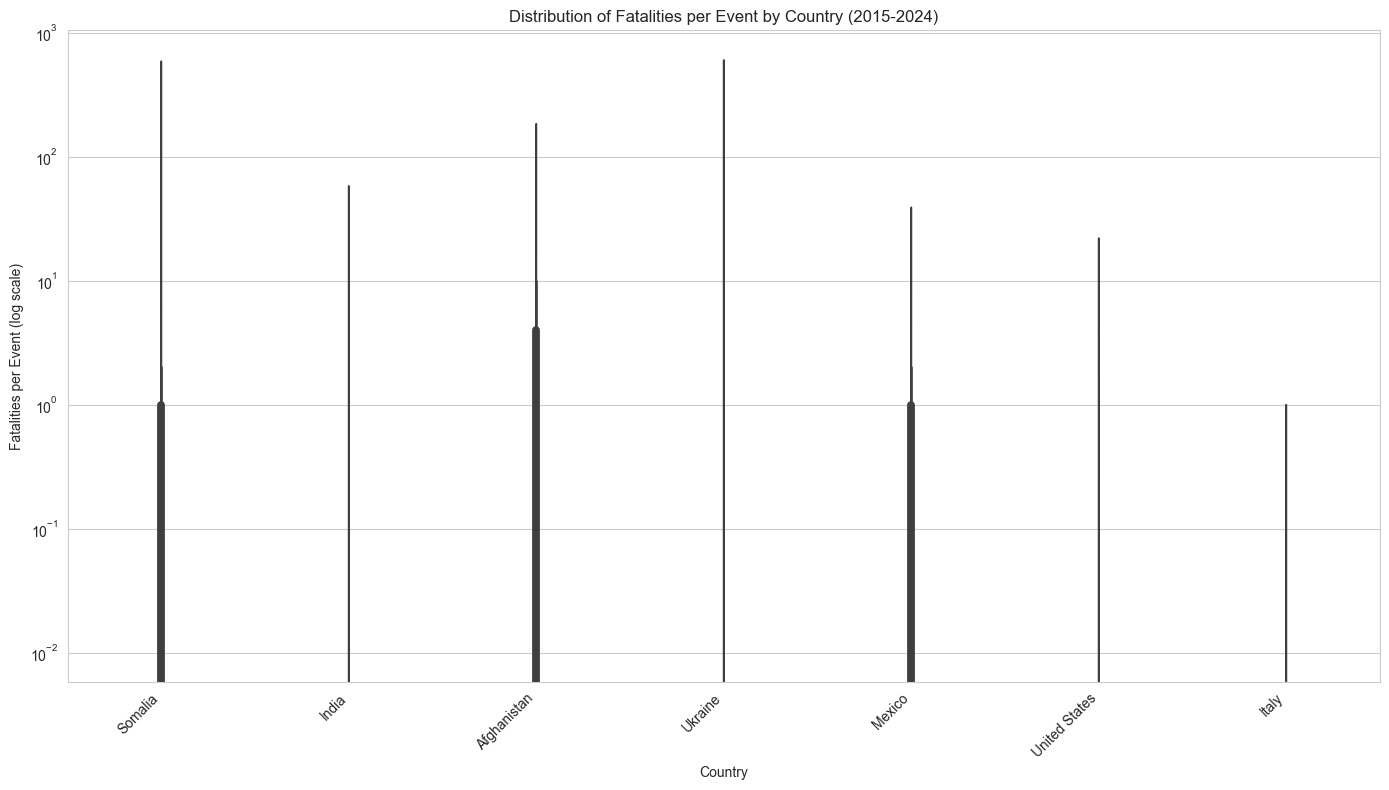

✓ Saved: viz2-3_violin_fatalities_distribution.json (7727.2 KB)

Data structure:
- 7 countries
- Total events: 658,273


In [ ]:
# Prepare metadata
viz3_metadata = {
    'title': 'Distribution of Fatalities per Event by Country',
    'description': 'Violin plot showing the distribution of fatalities per conflict event across 7 selected countries from 2015 to 2024. Each violin represents the probability density of fatalities, with wider sections indicating more events at that fatality level.',
    'source': 'ACLED',
    'date_range': f'{last_10_years_start}-{current_year}',
    'countries': violin_countries,
    'notes': 'Includes all events (including zero-fatality events).',
    'event_count': len(df_violin)
}

# Prepare data for JSON export
# Group by country for easier D3.js consumption
violin_data = []
for country in violin_countries:
    country_events = df_violin[df_violin['country'] == country]['fatalities'].tolist()
    violin_data.append({
        'country': country,
        'values': country_events,
        'count': len(country_events),
        'mean': float(np.mean(country_events)) if country_events else 0,
        'median': float(np.median(country_events)) if country_events else 0,
        'max': int(np.max(country_events)) if country_events else 0
    })

# Create output structure
viz3_output = {
    'metadata': viz3_metadata,
    'data': violin_data
}

# Save to JSON
output_file_viz3 = viz_datasets_path / 'viz2-3_violin_fatalities_distribution.json'
with open(output_file_viz3, 'w', encoding='utf-8') as f:
    json.dump(viz3_output, f, indent=2, ensure_ascii=False)

print(f"✓ Saved: {output_file_viz3.name} ({output_file_viz3.stat().st_size / 1024:.1f} KB)")
print(f"\nData structure:")
print(f"- {len(violin_data)} countries")
print(f"- Total events: {sum(d['count'] for d in violin_data):,}")

In [15]:
import pandas as pd
import numpy as np
import json
from pathlib import Path

# For visualizations (optional)
import matplotlib.pyplot as plt
import seaborn as sns

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Set style for plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [16]:
raw_data_path = Path('../raw-data')
processed_data_path = Path('../processed-data')

df_acled = pd.read_csv(raw_data_path / 'ACLED' / 'ACLED_2025-10-29.csv', encoding='utf-8-sig')
df_econ = pd.read_csv(processed_data_path / 'economics-countries-master.csv')

print(f"ACLED: {len(df_acled):,} events")
print(f"Economics: {len(df_econ):,} country-years")

# Get the current year from the data
current_year = df_acled['year'].max()
print(f"Latest year in data: {current_year}")

ACLED: 2,372,683 events
Economics: 10,936 country-years
Latest year in data: 2024
